# Data analysis template

This notebook shows how to read the output of the simulation in a pandas Dataframe. 


In [1]:
# Imports for HDF5 I/O, analysis and plotting
import h5py
import json
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
# Useful functions to read the output of the simulations

def read_stats_df(stats_path: Path) -> pd.DataFrame:
    # Read stats.h5 into a tidy DataFrame using stored fieldnames
    with h5py.File(stats_path, "r", swmr=True) as fh:
        dset = fh["stats"]
        dset.refresh()
        fieldnames = [s.decode("utf-8") for s in dset.attrs["fieldnames"]]
        return pd.DataFrame(dset[...], columns=fieldnames)

def read_state_df(state_path: Path) -> pd.DataFrame:
    # Read state.h5 into a DataFrame; each column is one agent state
    with h5py.File(state_path, "r", swmr=True) as fh:
        dset_state = fh["state"]
        dset_time = fh["time"]
        dset_step = fh["step"]
        dset_state.refresh()
        dset_time.refresh()
        dset_step.refresh()
        state = dset_state[...]
        df = pd.DataFrame(state, columns=[f"x_{i}" for i in range(state.shape[1])])
        df.insert(0, "t", dset_time[...])
        df.insert(0, "step", dset_step[...])
        return df

def read_timings(timings_path: Path) -> dict:
    return json.loads(Path(timings_path).read_text())

def read_config(config_path: Path) -> dict:
    return json.loads(Path(config_path).read_text())

Below we read the output of the simulations


In [3]:
results_dir = Path("./") # set the path of the directory where the output is

# Load outputs produced by the simulation
stats_df = read_stats_df(results_dir / "stats.h5")
state_df = read_state_df(results_dir / "state.h5")
parameters = read_config(results_dir / "config_used.json")
timings = read_timings(results_dir / "timings.json")

In [4]:
stats_df.head()

,step,t,order_param,phase_var
0,0.0,0.0,0.015103,3.256998
1,10.0,1.0,0.012435,3.250357
2,20.0,2.0,0.009854,3.263926
3,30.0,3.0,0.011180,3.261183
4,40.0,4.0,0.014968,3.261399


In [5]:
state_df.head()

,step,t,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_990,x_991,x_992,x_993,x_994,x_995,x_996,x_997,x_998,x_999
0,0,0.0,1.447064,2.730548,5.819454,1.105295,6.106428,0.602519,5.927126,4.213230,...,3.340706,5.533267,3.128988,2.803090,3.119696,3.539657,1.145154,1.222975,2.711283,5.574590
1,10,1.0,1.622233,2.839932,5.928690,1.054494,6.213152,0.794826,5.854749,4.221369,...,3.331797,5.398799,3.279373,2.791177,3.017739,3.311490,1.222010,1.345056,2.669588,5.182077
2,20,2.0,1.614761,2.846550,5.919497,1.094127,6.280252,0.903318,5.801083,4.284905,...,3.318466,5.466802,3.217056,2.631111,3.074529,3.303643,1.206651,1.364290,2.723318,5.252382
3,30,3.0,1.423520,2.950718,6.004327,1.126227,6.131178,1.024503,5.617509,4.320342,...,3.275808,5.336044,3.048262,2.564660,3.000885,3.367081,1.282234,1.571923,2.787423,5.302862
4,40,4.0,1.571976,2.999556,5.882000,0.974061,6.095991,1.083694,5.552415,4.202394,...,3.200872,5.447514,2.895298,2.618391,3.059884,3.421514,1.289764,1.557669,2.636049,5.370007


Sample plots: statistics over time and empirical measure at a given time

Text(0, 0.5, 'count')

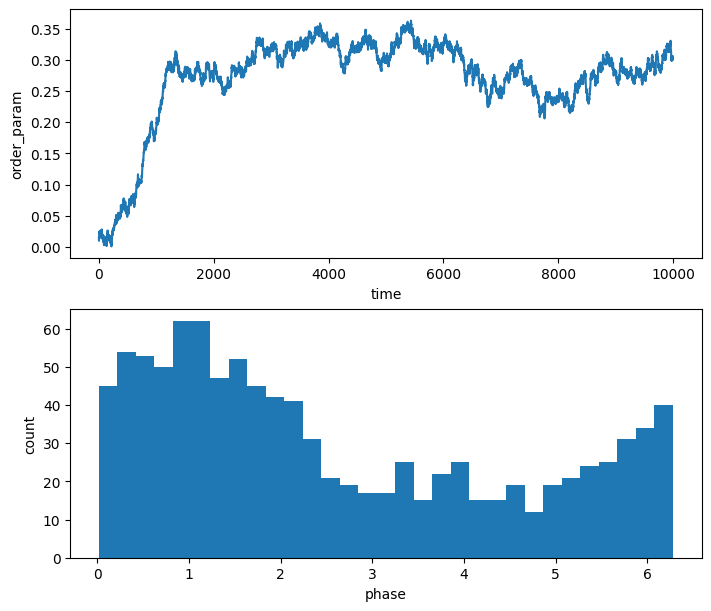

In [6]:
# Plot order parameter over time
fig, ax = plt.subplots(2, 1, figsize=(7, 6), constrained_layout=True)
stats_df.plot(x="t", y="order_param", ax=ax[0], legend=False)
ax[0].set_xlabel("time")
ax[0].set_ylabel("order_param")

# Histogram of phases at the last saved time
last_row = state_df.iloc[-1]
phase_values = last_row.filter(like="x_").to_numpy()
ax[1].hist(phase_values, bins=int(np.sqrt(phase_values.size)))
ax[1].set_xlabel("phase")
ax[1].set_ylabel("count")
